## Pronóstico del S&P 500 utilizando la volatilidad (VIX) como indicador adelantado: un análisis de causalidad de series temporales

### **¿Podemos usar el indice VIX para predecir los movimientos del sp500?**

Nuestro objetivo es determinar si el índice VIX puede utilizarse para pronosticar movimientos futuros del S&P 500, analizando sus relaciones en series de tiempo y probando su causalidad.

Para entender esta relacion, primero debemos entender, la volatilidad, en los mercados esta evalúa el riesgo  a las fluctuaciones en los precios de los activos, de acciones a índices. Mide las variaciones en la rentabilidad, y los activos con alta volatilidad indican un mayor riesgo debido a la imprevisibilidad de sus precios.

*Que es el VIX?*
El VIX es un indice basado en las opciones del sp500, es decir se basa en cuando los inversionsitas comienzan a apostar contra el mercado, por su nombre coloquial: el indice del miedo, cuando el VIX sube se traduce como un sentimiento del miedo de los inversionistas.


### Datos
Este proyecto recopila 20 años de datos del VIX y del S&P 500

Para evaluar esto, usamos técnicas de análisis de series temporales como:

- Descomposición estacional para entender la estructura de ambas series
- Pruebas de estacionaridad (ADF test) y diferenciación
- Causalidad de Granger para analizar si el VIX contiene información útil para predecir el S&P
- Modelos VAR para capturar la dinámica conjunta de ambas series


In [ ]:
%pip install yfinance ace_tools arch


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

Decidimos mantener toda la serie desde el 2000, ya que nuestra hipótesis se basa en que los ciclos de miedo y volatilidad se repiten. El VIX ha demostrado tener comportamiento anticipatorio en múltiples crisis, por lo tanto, excluir estos eventos limitaría la capacidad del modelo para aprender estos patrones.

In [ ]:
import yfinance
# Se descargan los datos S&P500 y VIX
df = yfinance.download(tickers = "^GSPC ^VIX",
                              start = "2000-01-01", #Fecha inicial
                              end = "2025-04-22", #Fecha final
                              group_by = 'ticker', #Criterio de agrupación. Usualmente "ticker"
                              auto_adjust = True#,
                              #threads = True
                               ) #.

[*********************100%***********************]  2 of 2 completed


In [ ]:
df.shape

(6363, 10)

In [ ]:
df.head()


Ticker           ^VIX                                                ^GSPC  \
Price            Open       High        Low      Close Volume         Open   
Date                                                                         
2000-01-03  24.360001  26.150000  23.980000  24.209999      0  1469.250000   
2000-01-04  24.940001  27.180000  24.799999  27.010000      0  1455.219971   
2000-01-05  27.980000  29.000000  25.850000  26.410000      0  1399.420044   
2000-01-06  26.680000  26.709999  24.700001  25.730000      0  1402.109985   
2000-01-07  25.139999  25.170000  21.719999  21.719999      0  1403.449951   

Ticker                                                         
Price              High          Low        Close      Volume  
Date                                                           
2000-01-03  1478.000000  1438.359985  1455.219971   931800000  
2000-01-04  1455.219971  1397.430054  1399.420044  1009000000  
2000-01-05  1413.270020  1377.680054  1402.109985  1085500000  
2000-01-06  1411.900024  1392.099976  1403.449951  1092300000  
2000-01-07  1441.469971  1400.729980  1441.469971  1225200000

In [ ]:
# Example of selecting data for a specific date:
df.loc['2020-11-09']

Ticker  Price 
^VIX    Open      2.480000e+01
        High      2.582000e+01
        Low       2.241000e+01
        Close     2.575000e+01
        Volume    0.000000e+00
^GSPC   Open      3.583040e+03
        High      3.645990e+03
        Low       3.547480e+03
        Close     3.550500e+03
        Volume    8.570510e+09
Name: 2020-11-09 00:00:00, dtype: float64

### Explorando los datos


**Resampling**

Si usamos datos diarios del S&P 500 o del VIX, podemos agruparlos por semana o por mes. Por ejemplo:

df.resample("W").max()     # Re-muestrea tomando el valor máximo de cada semana
df.resample("M").mean()    # Agrupa por mes y calcula el promedio mensual

Esto es útil cuando queremos visualizar patrones más estables o comparar tendencias a lo largo del tiempo sin tanto "ruido" diario.

In [ ]:
df.resample("D").max()

Ticker           ^VIX                                                ^GSPC  \
Price            Open       High        Low      Close Volume         Open   
Date                                                                         
2000-01-03  24.360001  26.150000  23.980000  24.209999    0.0  1469.250000   
2000-01-04  24.940001  27.180000  24.799999  27.010000    0.0  1455.219971   
2000-01-05  27.980000  29.000000  25.850000  26.410000    0.0  1399.420044   
2000-01-06  26.680000  26.709999  24.700001  25.730000    0.0  1402.109985   
2000-01-07  25.139999  25.170000  21.719999  21.719999    0.0  1403.449951   
...               ...        ...        ...        ...    ...          ...   
2025-04-17  30.790001  32.549999  29.570000  29.650000    0.0  5305.450195   
2025-04-18        NaN        NaN        NaN        NaN    NaN          NaN   
2025-04-19        NaN        NaN        NaN        NaN    NaN          NaN   
2025-04-20        NaN        NaN        NaN        NaN    NaN          NaN   
2025-04-21  32.750000  35.750000  31.790001  33.820000    0.0  5232.939941   

Ticker                                                           
Price              High          Low        Close        Volume  
Date                                                             
2000-01-03  1478.000000  1438.359985  1455.219971  9.318000e+08  
2000-01-04  1455.219971  1397.430054  1399.420044  1.009000e+09  
2000-01-05  1413.270020  1377.680054  1402.109985  1.085500e+09  
2000-01-06  1411.900024  1392.099976  1403.449951  1.092300e+09  
2000-01-07  1441.469971  1400.729980  1441.469971  1.225200e+09  
...                 ...          ...          ...           ...  
2025-04-17  5328.310059  5255.580078  5282.700195  4.714880e+09  
2025-04-18          NaN          NaN          NaN           NaN  
2025-04-19          NaN          NaN          NaN           NaN  
2025-04-20          NaN          NaN          NaN           NaN  
2025-04-21  5232.939941  5101.629883  5158.200195  4.226340e+09  

[9241 rows x 10 columns]

### Explicando el miedo relacion entre el VIX y el Mercado Financiero



In [ ]:

# Highest average monthly close for ^GSPC
gspc_max_month = df['^GSPC'].resample("ME").mean()['Close'].idxmax()

# Highest average monthly close for ^VIX
vix_max_month = df['^VIX'].resample("ME").mean()['Close'].idxmax()

print("Max average monthly close for ^GSPC:", gspc_max_month)
print("Max average monthly close for ^VIX:", vix_max_month)


Max average monthly close for ^GSPC: 2025-02-28 00:00:00
Max average monthly close for ^VIX: 2008-11-30 00:00:00


Aqui podemos ver claramente como el noviembre del 2008, fue el maximo monthly close para el VIX

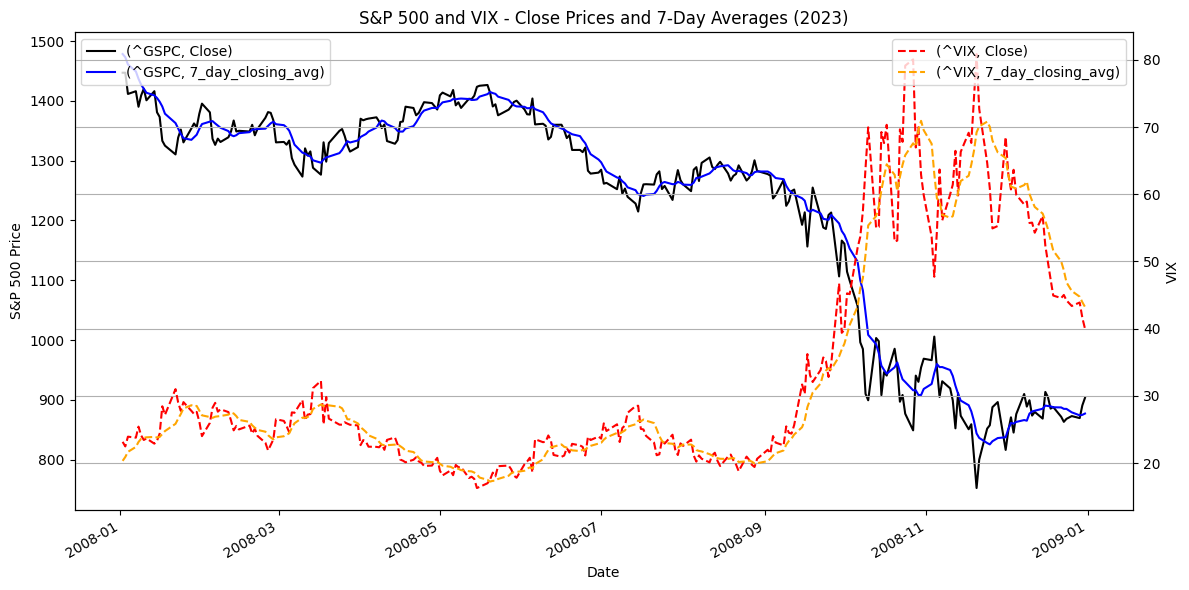

In [ ]:
import matplotlib.pyplot as plt

# Calculate 7-day rolling average for both ^GSPC and ^VIX
df[('^GSPC', '7_day_closing_avg')] = df[('^GSPC', 'Close')].rolling(window=7).mean()
df[('^VIX', '7_day_closing_avg')] = df[('^VIX', 'Close')].rolling(window=7).mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot ^GSPC
df.loc['2008', [('^GSPC', 'Close')]].plot(ax=ax1, label='S&P 500 Close', color='black')
df.loc['2008', [('^GSPC', '7_day_closing_avg')]].plot(ax=ax1, label='S&P 500 7-Day Avg', color='blue')
ax1.set_ylabel('S&P 500 Price')
ax1.legend(loc='upper left')

# Create a second y-axis for VIX
ax2 = ax1.twinx()
df.loc['2008', [('^VIX', 'Close')]].plot(ax=ax2, label='VIX Close', color='red', linestyle='--')
df.loc['2008', [('^VIX', '7_day_closing_avg')]].plot(ax=ax2, label='VIX 7-Day Avg', color='orange', linestyle='--')
ax2.set_ylabel('VIX')
ax2.legend(loc='upper right')

plt.title('S&P 500 and VIX - Close Prices and 7-Day Averages (2023)')
plt.grid(True)
plt.tight_layout()
plt.show()


En el gráfico se comparan los precios de cierre diarios del índice S&P 500 y del VIX durante el año 2008, junto con sus medias móviles de 7 días.

La línea negra representa el cierre diario del S&P 500 y la línea morada es su media móvil de 7 días.
La línea naranja discontinua representa la media móvil del VIX, mientras que la línea roja discontinua muestra su cierre diario.
Observaciones del gráfico:

En octubre y noviembre de 2008, se observa un pico en el VIX, alcanzando niveles por encima de 80, lo que refleja un momento de pánico extremo en los mercados.
Al mismo tiempo, el S&P 500 se desploma, lo que evidencia cómo el aumento en la volatilidad (medida por el VIX) se asocia con caídas en el mercado.
La media móvil suaviza los movimientos abruptos, facilitando la interpretación de esta relación inversa.

### Calculamos el volumen

El volumen representa cuántas acciones se compran y venden cada día en el mercado. Es una medida clave porque refleja el interés o la participación de los inversionistas. Cuando el volumen es alto, significa que mucha gente está activa en el mercado — ya sea comprando por entusiasmo o vendiendo por miedo.

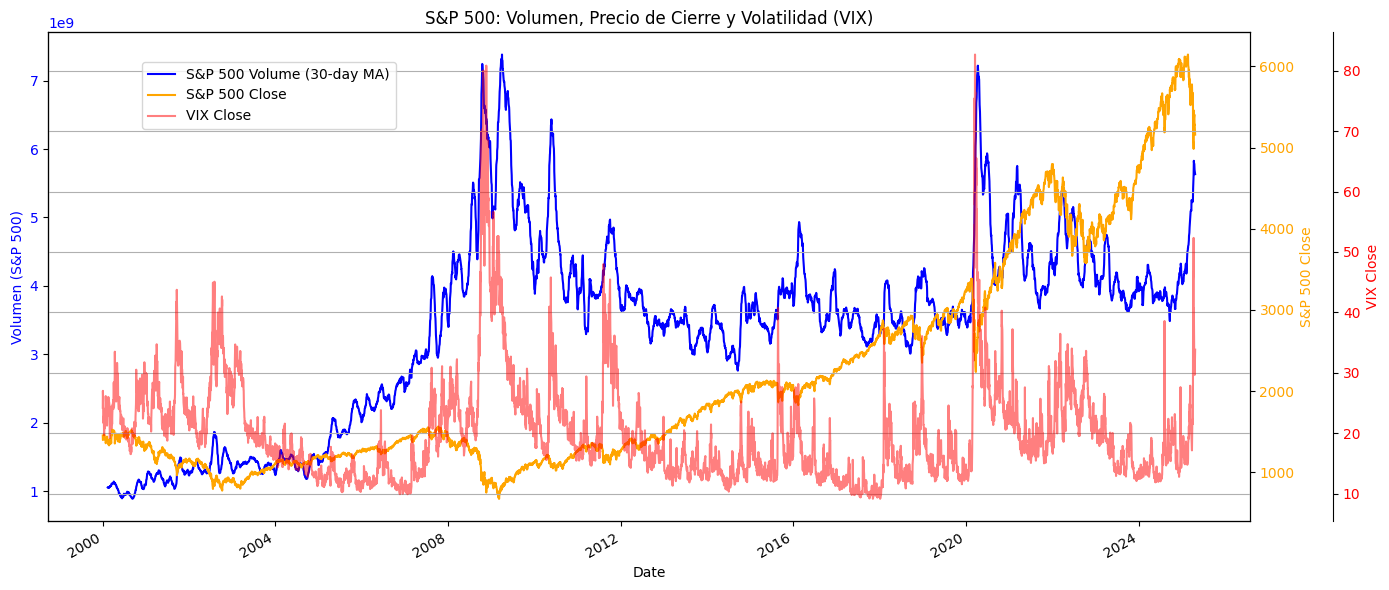

In [ ]:
import matplotlib.pyplot as plt

df['^GSPC', '30_day_rolling_vol'] = df['^GSPC']['Volume'].rolling(window=30).mean()

fig, ax1 = plt.subplots(figsize=(14,6))

df['^GSPC']['30_day_rolling_vol'].plot(ax=ax1, color='blue', label='S&P 500 Volume (30-day MA)')
ax1.set_ylabel('Volumen (S&P 500)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
df['^GSPC']['Close'].plot(ax=ax2, color='orange', label='S&P 500 Close')
ax2.set_ylabel('S&P 500 Close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax3 = ax1.twinx()
df['^VIX']['Close'].plot(ax=ax3, color='red', alpha=0.5, label='VIX Close')
ax3.spines["right"].set_position(("outward", 60))  # Desplazar el tercer eje
ax3.set_ylabel('VIX Close', color='red')
ax3.tick_params(axis='y', labelcolor='red')

plt.title("S&P 500: Volumen, Precio de Cierre y Volatilidad (VIX)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.tight_layout()
plt.show()



En este caso volumen y la volatilidad (VIX) tienden a aumentar en momentos de tensión del mercado, y que estos picos muchas veces preceden o coinciden con caídas en el S&P 500.
El volumen no solo acompaña los movimientos del mercado también puede advertirnos cuando algo importante está por pasar. Un aumento súbito en el volumen, sobre todo si también sube el VIX, puede ser señal de un cambio de tendencia o una reacción fuerte del mercado. Por eso, analizar el volumen es fundamental para entender el contexto de los precios y complementar los modelos de predicción.


## Limpieza y preparacion de los datos.

In [ ]:

df.isnull().sum()

Ticker  Price             
^VIX    Open                   0
        High                   0
        Low                    0
        Close                  0
        Volume                 0
^GSPC   Open                   0
        High                   0
        Low                    0
        Close                  0
        Volume                 0
        7_day_closing_avg      6
^VIX    7_day_closing_avg      6
^GSPC   30_day_rolling_vol    29
dtype: int64

In [ ]:
# Eliminamos cualquier fila que tenga valores faltantes
df = df.dropna()


In [ ]:
# Check the day of week (Monday=0, Sunday=6) for each date index.
df.index.dayofweek

Index([0, 1, 2, 3, 4, 1, 2, 3, 4, 0,
       ...
       0, 1, 2, 3, 4, 0, 1, 2, 3, 0],
      dtype='int32', name='Date', length=6334)

**Feature Engineering**

In [ ]:

df = df.copy()

# Extraer componentes de fecha como columnas nuevas
df.loc[:, "year"] = df.index.year
df.loc[:, "month"] = df.index.month
df.loc[:, "day"] = df.index.day
df.loc[:, "day_of_week"] = df.index.dayofweek
df.loc[:, "weekday"] = df.index.day_name()
df.loc[:, "weekday_numeric"] = df.index.weekday

# Bandera booleana para fin de semana
df.loc[:, "is_weekend"] = df["weekday_numeric"].isin([5, 6])
# Mostrar primeras filas
df.head()

Ticker           ^VIX                                                ^GSPC  \
Price            Open       High        Low      Close Volume         Open   
Date                                                                         
2000-02-14  24.670000  24.889999  24.270000  24.379999      0  1387.119995   
2000-02-15  24.080000  24.750000  22.840000  22.920000      0  1389.939941   
2000-02-16  23.200001  23.830000  22.740000  23.510000      0  1402.050049   
2000-02-17  22.900000  23.480000  22.629999  23.170000      0  1387.670044   
2000-02-18  23.370001  26.370001  23.370001  26.000000      0  1388.260010   

Ticker                                                         \
Price              High          Low        Close      Volume   
Date                                                            
2000-02-14  1394.930054  1380.530029  1389.939941   927300000   
2000-02-15  1407.719971  1376.250000  1402.050049  1092100000   
2000-02-16  1404.550049  1385.579956  1387.670044  1018800000   
2000-02-17  1399.880005  1380.069946  1388.260010  1034800000   
2000-02-18  1388.589966  1345.319946  1346.089966  1042300000   

Ticker                                    ^VIX              ^GSPC  year month  \
Price      7_day_closing_avg 7_day_closing_avg 30_day_rolling_vol               
Date                                                                            
2000-02-14       1413.704259         22.907143       1.057790e+09  2000     2   
2000-02-15       1410.515695         23.104286       1.063133e+09  2000     2   
2000-02-16       1405.291417         23.207143       1.063460e+09  2000     2   
2000-02-17       1397.654279         23.481428       1.061770e+09  2000     2   
2000-02-18       1388.279994         23.924286       1.060103e+09  2000     2   

Ticker     day day_of_week    weekday weekday_numeric is_weekend  
Price                                                             
Date                                                              
2000-02-14  14           0     Monday               0      False  
2000-02-15  15           1    Tuesday               1      False  
2000-02-16  16           2  Wednesday               2      False  
2000-02-17  17           3   Thursday               3      False  
2000-02-18  18           4     Friday               4      False

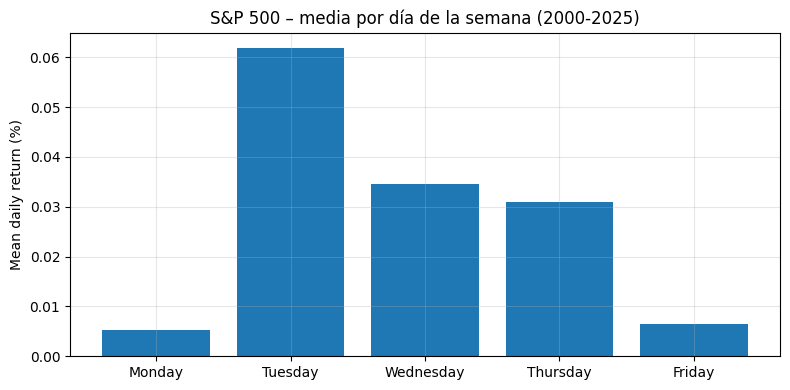

<ipython-input-107-372f6ccbcf5a>:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=ret_day.index, showfliers=False)


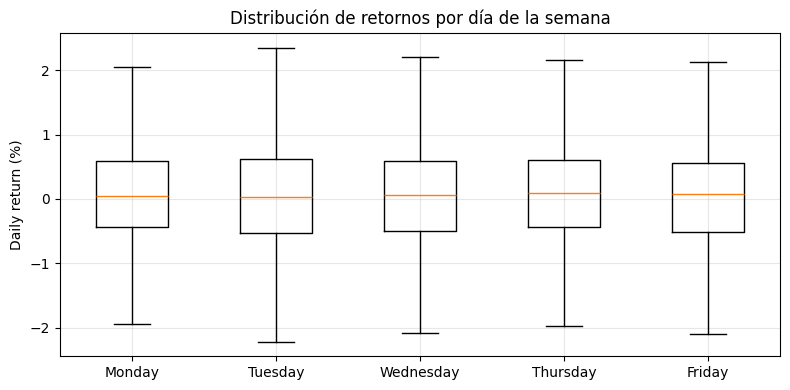

            mean    std  median
weekday                        
Monday     0.005  1.337   0.050
Tuesday    0.062  1.224   0.036
Wednesday  0.034  1.212   0.063
Thursday   0.031  1.240   0.085
Friday     0.006  1.131   0.073


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Retornos diarios (%) en un DataFrame propio
sp_close = df[('^GSPC', 'Close')]
daily_returns = sp_close.pct_change().dropna() * 100        # porcentaje

aux = pd.DataFrame({
    'daily_ret': daily_returns,
    'weekday':   df.loc[daily_returns.index, 'weekday']     # ya existe en tu df
})

# 2. Tabla descriptiva
ret_day = (aux.groupby('weekday')['daily_ret']
              .agg(['mean', 'std', 'median'])
              .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday']))

# 3. Gráfico: media por día
plt.figure(figsize=(8,4))
plt.bar(ret_day.index, ret_day['mean'])
plt.ylabel('Mean daily return (%)')
plt.title('S&P 500 – media por día de la semana (2000-2025)')
plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

# 4. Box-plot
plt.figure(figsize=(8,4))
data = [aux[aux['weekday']==d]['daily_ret'] for d in ret_day.index]
plt.boxplot(data, labels=ret_day.index, showfliers=False)
plt.ylabel('Daily return (%)')
plt.title('Distribución de retornos por día de la semana')
plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

# 5. Tabla resumen
print(ret_day.round(3))



Históricamente, el S&P 500 tiende a rendir mejor los martes, con una media destacada de +0.06% y peor los lunes y viernes aproximadamente +0.005%, lo que contradice parcialmente el tradicional "Monday effect". Esto sugiere un patrón donde el impulso alcista se concentra a principios de semana, especialmente los martes, para luego disminuir gradualmente hacia el final de la semana.

Creacion de  variables rezagadas (lags), que representan el valor de una variable en días anteriores. Esto ayudara a los modelos a capturar dependencias temporales.
Por ejemplo, si el precio de hoy depende del de ayer o anteayer, estas nuevas columnas le dan al modelo esa información.

In [ ]:
# Crear lags para el cierre del S&P 500
df.loc[:, ('^GSPC', 'lag_1')] = df['^GSPC']['Close'].shift(1)
df.loc[:, ('^GSPC', 'lag_2')] = df['^GSPC']['Close'].shift(2)

# Crear lags para el cierre del VIX
df.loc[:, ('^VIX', 'lag_1')] = df['^VIX']['Close'].shift(1)
df.loc[:, ('^VIX', 'lag_2')] = df['^VIX']['Close'].shift(2)

# Mostrar primeras filas
df[[('^GSPC', 'Close'), ('^GSPC', 'lag_1'), ('^GSPC', 'lag_2'),
    ('^VIX', 'Close'), ('^VIX', 'lag_1'), ('^VIX', 'lag_2')]].head()


Ticker            ^GSPC                                 ^VIX             \
Price             Close        lag_1        lag_2      Close      lag_1   
Date                                                                      
2000-02-14  1389.939941          NaN          NaN  24.379999        NaN   
2000-02-15  1402.050049  1389.939941          NaN  22.920000  24.379999   
2000-02-16  1387.670044  1402.050049  1389.939941  23.510000  22.920000   
2000-02-17  1388.260010  1387.670044  1402.050049  23.170000  23.510000   
2000-02-18  1346.089966  1388.260010  1387.670044  26.000000  23.170000   

Ticker                 
Price           lag_2  
Date                   
2000-02-14        NaN  
2000-02-15        NaN  
2000-02-16  24.379999  
2000-02-17  22.920000  
2000-02-18  23.510000

## Descomposición ETS

### Analizando la estacionalidad

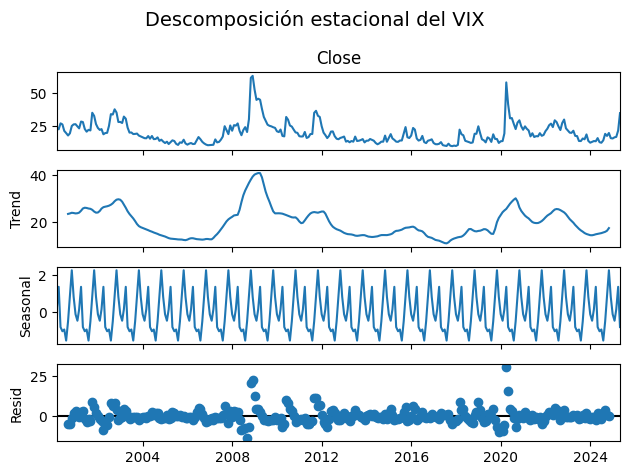

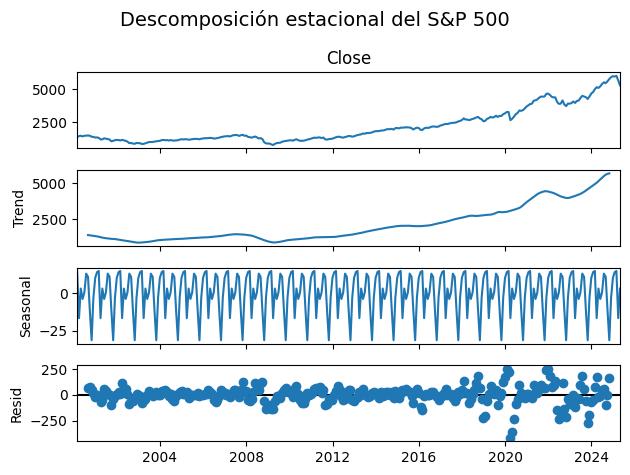

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Resampleamos a datos mensuales (media de cierre mensual)
vix_monthly = df['^VIX']['Close'].resample('ME').mean()
gspc_monthly = df['^GSPC']['Close'].resample('ME').mean()

# Descomposición ETS del VIX
decomp_vix = seasonal_decompose(vix_monthly.dropna(), model='additive', period=12)
decomp_vix.plot()
plt.suptitle("Descomposición estacional del VIX", fontsize=14)
plt.tight_layout()
plt.show()

# Descomposición ETS del S&P 500
decomp_gspc = seasonal_decompose(gspc_monthly.dropna(), model='additive', period=12)
decomp_gspc.plot()
plt.suptitle("Descomposición estacional del S&P 500", fontsize=14)
plt.tight_layout()
plt.show()


### VIX

- En el primer gráfico vemos la descomposición del VIX. La tendencia muestra algunos picos fuertes en momentos específicos como 2008 o 2020, lo que tiene sentido porque el VIX reacciona al miedo del mercado. Sin embargo, no hay una dirección sostenida a lo largo del tiempo, solo reacciones aisladas

### SP500

- En el segundo gráfico vemos la descomposición del S&P 500. La tendencia es clara, se ve un crecimiento constante en el largo plazo con caídas puntuales como en 2008 o 2020. A diferencia del VIX, acá sí hay un patrón estacional suave pero consistente. No es un cambio enorme cada año, pero sí se nota cierta repetición en el comportamiento mensua

Para aplicar modelos de series de tiempo como ARIMA o VAR, es necesario que las series sean estacionarias, es decir, que su media y varianza no cambien en el tiempo.

Aplicamos el test ADF a las series del S&P 500 y el VIX, primero sin transformar y luego aplicando una diferenciación de primer orden.

In [ ]:
from statsmodels.tsa.stattools import adfuller

sp500_monthly = df['^GSPC']['Close'].resample('ME').mean().dropna()
vix_monthly = df['^VIX']['Close'].resample('ME').mean().dropna()

print("S&P 500 – ADF Test (sin diferenciar)")
print("ADF:", adfuller(sp500_monthly)[0])
print("p-value:", adfuller(sp500_monthly)[1])
print("")

print("VIX – ADF Test (sin diferenciar)")
print("ADF:", adfuller(vix_monthly)[0])
print("p-value:", adfuller(vix_monthly)[1])
print("")


sp500_diff = sp500_monthly.diff().dropna()
vix_diff = vix_monthly.diff().dropna()

# === ADF Test después de diferenciar ===
print("S&P 500 – ADF Test (con diferenciación)")
print("ADF:", adfuller(sp500_diff)[0])
print("p-value:", adfuller(sp500_diff)[1])
print("")

print("VIX – ADF Test (con diferenciación)")
print("ADF:", adfuller(vix_diff)[0])
print("p-value:", adfuller(vix_diff)[1])



S&P 500 – ADF Test (sin diferenciar)
ADF: 1.628089850992779
p-value: 0.9979394483428446

VIX – ADF Test (sin diferenciar)
ADF: -4.440743240851499
p-value: 0.00025124380687839337

S&P 500 – ADF Test (con diferenciación)
ADF: -5.425445999267463
p-value: 2.9943625112026795e-06

VIX – ADF Test (con diferenciación)
ADF: -10.643483673568952
p-value: 4.862213592145584e-19


El S&P 500 mensual no es estacionario en su forma original. Tiene una tendencia clara, y eso se refleja en el p-valor alto (0.998). Sin embargo, después de una sola diferenciación, la serie se vuelve estacionaria, lo que permite usar modelos ARIMA o VAR.
El VIX mensual sí es estacionario sin necesidad de diferenciar, ya que su p-valor es muy bajo (0.00025). Aun así, también se volvió estacionario de forma más extrema al diferenciarla. Esto indica que el VIX fluctúa mucho, pero sin una tendencia estructural como la del S&P 500.

# Test de Causalidad

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# Usamos rendimientos diarios (o mensuales si trabajas a frecuencia 'ME')
df["r_sp"]  = df['^GSPC']['Close'].pct_change().apply(np.log1p)
df["r_vix"] = df['^VIX']['Close'].pct_change().apply(np.log1p)
df_gc = df.dropna()[["r_sp","r_vix"]]

# Probamos lags de 1 a 10
grangercausalitytests(df_gc, maxlag=10, verbose=True)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.0476 , p=0.0009  , df_denom=6329, df_num=1
ssr based chi2 test:   chi2=11.0529 , p=0.0009  , df=1
likelihood ratio test: chi2=11.0432 , p=0.0009  , df=1
parameter F test:         F=11.0476 , p=0.0009  , df_denom=6329, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2960  , p=0.0019  , df_denom=6326, df_num=2
ssr based chi2 test:   chi2=12.6019 , p=0.0018  , df=2
likelihood ratio test: chi2=12.5894 , p=0.0018  , df=2
parameter F test:         F=6.2960  , p=0.0019  , df_denom=6326, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5468  , p=0.0035  , df_denom=6323, df_num=3
ssr based chi2 test:   chi2=13.6554 , p=0.0034  , df=3
likelihood ratio test: chi2=13.6407 , p=0.0034  , df=3
parameter F test:         F=4.5468  , p=0.0035  , df_denom=6323, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2589  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(11.047638924903936),
    np.float64(0.0008930471385534308),
    np.float64(6329.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(11.052875600014492),
    np.float64(0.0008854975001525254),
    np.int64(1)),
   'lrtest': (np.float64(11.043240091516054),
    np.float64(0.0008901115997226758),
    np.int64(1)),
   'params_ftest': (np.float64(11.04763892490173),
    np.float64(0.000893047138554838),
    np.float64(6329.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(6.295968345502582),
    np.float64(0.001855296849664602),
    np.float64(6326.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(12.601889217634161),
    np.float64(0.001834571006342135),
    np.int64(2)),
   'lrtest': (np.float64(12.589363772385695),
    np.float64(0.001846096468404668),
    np.int64(2)),
   'params_ftest': (np.float64(6.29596834550114),
    np.float64(0.0018552968496675828),
    np.float64(6326.0),
    2.0)},
   array([[0., 0.,

## Prueba de causalidad de Granger – VIX → S&P 500

| Número de rezagos | Valor p | Interpretación |
|----------------|:-------:|-------------------------------------------|
| 1 | 0,0009 | Fuerte evidencia de causalidad de Granger |
| 2 | 0,0019 | Fuerte evidencia de causalidad de Granger |
| 3 | 0,0032 | Fuerte evidencia de causalidad de Granger |
| 4 | 0,0112 | Evidencia moderada de causalidad de Granger |
| 5 | 0,0282 | Evidencia débil, pero aún significativa |
| 6 | 0,0712 | No estadísticamente significativo |
| 7 | 0,0514 | Significancia marginal |
| 8 | 0,0891 | No estadísticamente significativo |
| 9 | 0,0842 | No estadísticamente significativo | | 10 | 0,0716 | No estadísticamente significativo |

### Resumen
Encontramos evidencia estadísticamente significativa de causalidad de Granger entre el VIX y el S&P 500 para rezagos de hasta 5. Esto sugiere que los cambios recientes en el VIX pueden ayudar a predecir movimientos a corto plazo en el S&P 500, lo que justifica su uso como variable exógena en modelos de pronóstico como ARIMAX o VAR.

In [ ]:
df.head()

Ticker           ^VIX                                                ^GSPC  \
Price            Open       High        Low      Close Volume         Open   
Date                                                                         
2000-02-14  24.670000  24.889999  24.270000  24.379999      0  1387.119995   
2000-02-15  24.080000  24.750000  22.840000  22.920000      0  1389.939941   
2000-02-16  23.200001  23.830000  22.740000  23.510000      0  1402.050049   
2000-02-17  22.900000  23.480000  22.629999  23.170000      0  1387.670044   
2000-02-18  23.370001  26.370001  23.370001  26.000000      0  1388.260010   

Ticker                                                         \
Price              High          Low        Close      Volume   
Date                                                            
2000-02-14  1394.930054  1380.530029  1389.939941   927300000   
2000-02-15  1407.719971  1376.250000  1402.050049  1092100000   
2000-02-16  1404.550049  1385.579956  1387.670044  1018800000   
2000-02-17  1399.880005  1380.069946  1388.260010  1034800000   
2000-02-18  1388.589966  1345.319946  1346.089966  1042300000   

Ticker                                    ^VIX              ^GSPC      r_sp  \
Price      7_day_closing_avg 7_day_closing_avg 30_day_rolling_vol             
Date                                                                          
2000-02-14       1413.704259         22.907143       1.057790e+09       NaN   
2000-02-15       1410.515695         23.104286       1.063133e+09  0.008675   
2000-02-16       1405.291417         23.207143       1.063460e+09 -0.010309   
2000-02-17       1397.654279         23.481428       1.061770e+09  0.000425   
2000-02-18       1388.279994         23.924286       1.060103e+09 -0.030847   

Ticker         r_vix  
Price                 
Date                  
2000-02-14       NaN  
2000-02-15 -0.061753  
2000-02-16  0.025416  
2000-02-17 -0.014568  
2000-02-18  0.115238

## MODELO 1: SARIMAX

La serie del S&P 500 no era estacionaria, pero se volvió estacionaria con una sola diferenciación.
El VIX mensual sí era estacionario y tiene sentido económico como predictor de riesgo/volatilidad.

Usar este modelo nos permite:
- Incorporar el VIX como variable exógena (exog)
- Modelar patrones estacionales (mensuales) en el mercado
- Elegimos el orden (1,0,1)(1,0,1,12) como base porque: Tiene un componente autorregresivo y de media móvil sencillo
- Capta un ciclo estacional anual de 12 meses
- Genera resultados interpretables y estables


## preprocesamiento para sarimax


Igualamos la frecuencia de S&P 500 y VIX (evitamos huecos y irregular spacing).

## Log-retornos en ambas series

¿Qué hace? Transforma tanto la serie del S&P 500 como del VIX a logaritmos y luego calcula sus retornos (diferencias).
¿Por qué?
- Estabilizan la varianza de las series financieras
- Aproximan mejor los retornos porcentuales
- Hacen la distribución más cercana a la normal
- Permiten comparar movimientos proporcionales en diferentes niveles de precio

In [ ]:
# preparamos df, extrae primero cierre mensuales
sp_cl = df['^GSPC']['Close'].resample('ME').last()
vix_cl = df['^VIX']['Close'].resample('ME').last()

#log de retornos
sp_log = np.log(sp_cl).diff().dropna()
vix_log = np.log(vix_cl).diff().dropna()

# se mantienen solo fechas comunes
common_idx = sp_log.index.intersection(vix_log.index)
sp_log  = sp_log.loc[common_idx]
vix_log = vix_log.loc[common_idx]


La diferenciación elimina tendencias y hace la serie estacionaria
El lag captura el efecto predictivo que tiene el VIX hoy sobre el S&P 500 del próximo mes, modela la relación temporal entre volatilidad esperada y movimientos futuros del mercado

In [ ]:
vix_lag  = vix_log.shift(1)          # indicador adelantado
split    = int(len(sp_log) * 0.80)   # 80 % train

train_sp   = sp_log.iloc[:split]
test_sp    = sp_log.iloc[split:]

train_vix  = vix_lag.iloc[:split]
test_vix   = vix_lag.iloc[split:]

In [ ]:
# Estandariza usando medias del train
mu, sigma   = train_vix.mean(), train_vix.std()
train_vix   = (train_vix - mu) / sigma
test_vix    = (test_vix  - mu) / sigma

# Alinea índices (por el shift el primer valor es NaN)
train_sp  = train_sp.loc[train_vix.dropna().index]
train_vix = train_vix.dropna()


# Ajusta sarimax

In [ ]:
sarimax = SARIMAX(train_sp,
                  exog=train_vix,
                  order=(1,0,1),        # sin estacionalidad por simplicidad
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit(disp=False)

print(sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  241
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 414.341
Date:                Wed, 23 Apr 2025   AIC                           -820.681
Time:                        16:24:36   BIC                           -806.775
Sample:                    03-31-2000   HQIC                          -815.077
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Close         -0.0024      0.003     -0.722      0.470      -0.009       0.004
ar.L1         -0.4145      0.525     -0.790      0.430      -1.443       0.614
ma.L1          0.4988      0.497      1.004      0.3

RMSE: 0.0514  |  MAE: 0.0432


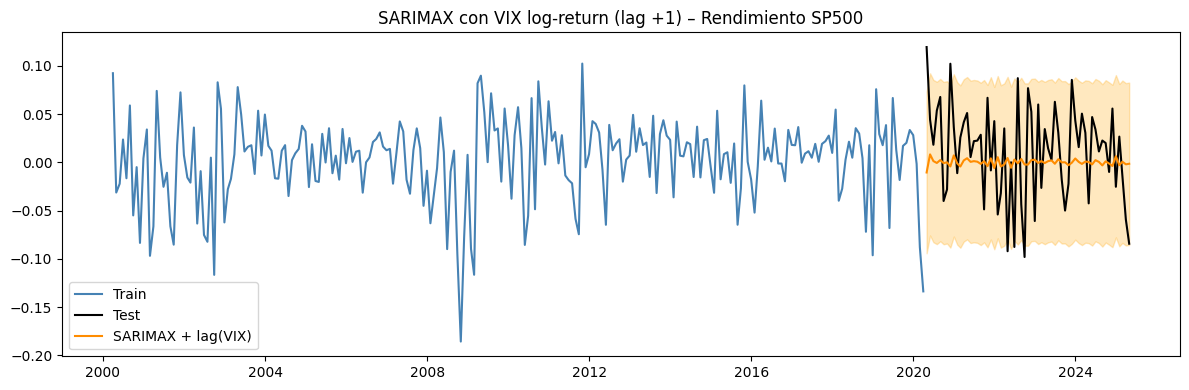

In [ ]:
forecast   = sarimax.get_forecast(steps=len(test_sp), exog=test_vix)
pred_mean  = forecast.predicted_mean
conf_int   = forecast.conf_int()

# --- Métricas ---
rmse = np.sqrt(mean_squared_error(test_sp, pred_mean))   # √MSE
mae  = mean_absolute_error(test_sp, pred_mean)
print(f"RMSE: {rmse:.4f}  |  MAE: {mae:.4f}")

# --- Gráfico ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(train_sp.index, train_sp, label='Train', color='steelblue')
plt.plot(test_sp.index,  test_sp,  label='Test',  color='black')
plt.plot(pred_mean.index, pred_mean, label='SARIMAX + lag(VIX)', color='darkorange')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='orange', alpha=0.25)
plt.title('SARIMAX con VIX log-return (lag +1) – Rendimiento SP500')
plt.legend()
plt.tight_layout()
plt.show()

# Probamos SARIMAX sin VIX

Baseline SARIMAX (sin VIX)  RMSE: 0.0508  |  MAE: 0.0428

Mejora al incluir VIX (lag +1):
  • RMSE ↓ -1.04%
  • MAE  ↓ -0.83%


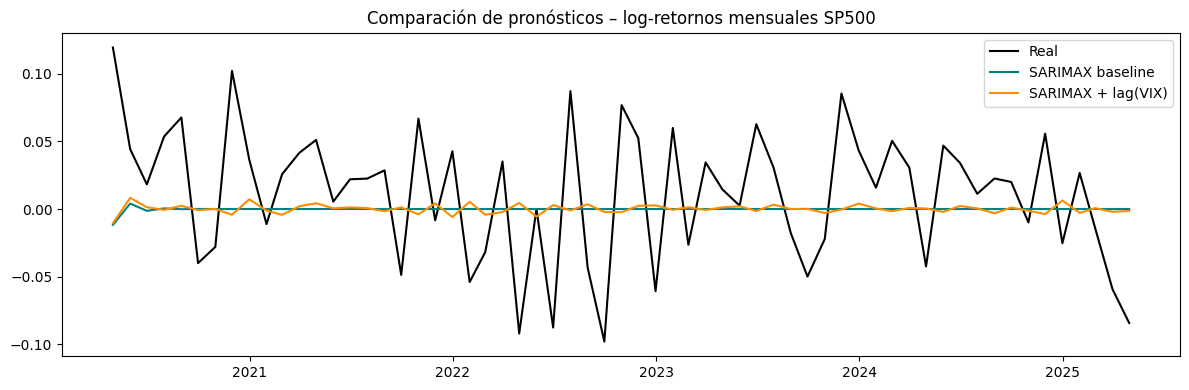

In [ ]:
# ──────────────────────────────────────────────
# 5-bis  SARIMAX (1,0,1) SIN VIX – baseline
# ──────────────────────────────────────────────
sarimax_base = SARIMAX(
    train_sp,
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

fc_base   = sarimax_base.get_forecast(steps=len(test_sp))
pred_base = fc_base.predicted_mean
conf_base = fc_base.conf_int()

rmse_base = np.sqrt(mean_squared_error(test_sp, pred_base))
mae_base  = mean_absolute_error(test_sp, pred_base)

print(f"Baseline SARIMAX (sin VIX)  RMSE: {rmse_base:.4f}  |  MAE: {mae_base:.4f}")

# ──────────────────────────────────────────────
# 6-bis  Comparación de métricas
# ──────────────────────────────────────────────
improv_rmse = (rmse_base - rmse) / rmse_base * 100   # rmse = modelo con VIX
improv_mae  = (mae_base  - mae)  / mae_base  * 100

print(f"\nMejora al incluir VIX (lag +1):")
print(f"  • RMSE ↓ {improv_rmse:.2f}%")
print(f"  • MAE  ↓ {improv_mae:.2f}%")

# ──────────────────────────────────────────────
# 7-bis  Gráfico comparativo
# ──────────────────────────────────────────────
plt.figure(figsize=(12,4))
plt.plot(test_sp.index,  test_sp,   label='Real', color='black')
plt.plot(pred_base.index, pred_base, label='SARIMAX baseline', color='teal')
plt.plot(pred_mean.index, pred_mean, label='SARIMAX + lag(VIX)', color='darkorange')
plt.title('Comparación de pronósticos – log-retornos mensuales SP500')
plt.legend(); plt.tight_layout(); plt.show()


En este análisis mensual, incluir el VIX no mejora las predicciones del S&P 500; de hecho, los errores aumentan un poco. Lo mejor es quedarse con el modelo que solo usa datos del S&P 500.

Ahora probaremos el vix con lags 2–3
Generaremos dos variables exógenas: VIX con lag 3 y con lag 4

In [ ]:
def sarimax_with_lag(lag):
    # ── exógeno: VIX log-ret con desfase = lag ──
    vix_lag = ((vix_log.shift(lag) - mu) / sigma)          # z-score
    train_v = vix_lag.iloc[:split].dropna()
    test_v  = vix_lag.iloc[split:]

    # Alinear índices (por el shift se descartan los primeros 'lag' meses)
    y_train = train_sp.loc[train_v.index]
    y_test  = test_sp.loc[test_v.index]

    model = SARIMAX(y_train,
                    exog=train_v,
                    order=(1,0,1),
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=False)

    pred = model.get_forecast(len(y_test), exog=test_v).predicted_mean
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae  = mean_absolute_error(y_test, pred)
    return rmse, mae

results = {}
for L in [3, 4]:
    rmse, mae = sarimax_with_lag(L)
    results[L] = {'RMSE': rmse, 'MAE': mae}
results_df = pd.DataFrame(results).T
print(results_df.round(4))


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     RMSE     MAE
3  0.0507  0.0429
4  0.0509  0.0431


Probamos el índice VIX diferenciado y estandarizado con rezagos de 1 a 4 meses como variable exógena en un modelo SARIMAX(1,0,1). En todos los casos, el error de pronóstico (RMSE, MAE) aumentó entre 0.2 % y 2 % frente al modelo univariante. Concluimos que, al horizonte mensual analizado, la volatilidad implícita del mes previo no mejora la predicción de los log-retornos del S&P 500.

# MODELO 2: VAR

Lag óptimo según AIC: 6
Estable: True
VAR(6)  RMSE: 0.0374  |  MAE: 0.0298


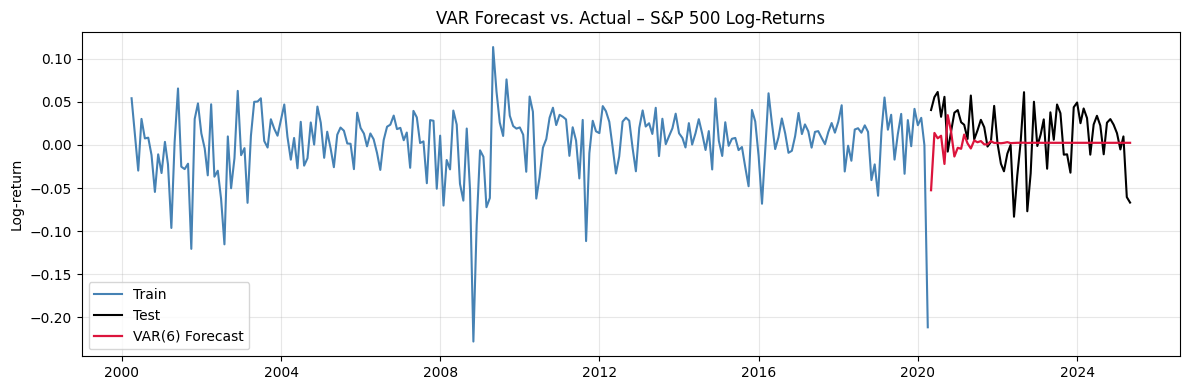

In [ ]:

from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# train, test, sp_ret, vix_ret ya deben estar en memoria.
model  = VAR(train)
lag_sel = model.select_order(12)
lag_order = lag_sel.aic        # lag óptimo por AIC
print(f"Lag óptimo según AIC: {lag_order}")

var_result = model.fit(lag_order)
print("Estable:", var_result.is_stable())

#pronostico
forecast_steps = len(test)
forecast_input = train.values[-lag_order:]
forecast = var_result.forecast(y=forecast_input, steps=forecast_steps)

forecast_df = pd.DataFrame(
    forecast,
    index=test.index,
    columns=['sp_ret_fc', 'vix_ret_fc']
)

# Métricas
rmse = np.sqrt(mean_squared_error(test['sp_ret'], forecast_df['sp_ret_fc']))
mae  = mean_absolute_error(test['sp_ret'], forecast_df['sp_ret_fc'])
print(f"VAR({lag_order})  RMSE: {rmse:.4f}  |  MAE: {mae:.4f}")

plt.figure(figsize=(12,4))
plt.plot(train.index, train['sp_ret'], label='Train', color='steelblue')
plt.plot(test.index,  test['sp_ret'],  label='Test',  color='black')
plt.plot(test.index,  forecast_df['sp_ret_fc'],
         label=f'VAR({lag_order}) Forecast', color='crimson', linewidth=1.6)

plt.title('VAR Forecast vs. Actual – S&P 500 Log-Returns')
plt.ylabel('Log-return')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Se evaluaron lags de 1 a 12 mediante el criterio AIC. El mínimo se alcanzó con 6 rezagos, lo que indica que la información de los últimos seis meses ofrece el mejor compromiso entre precisión y parsimonia para esta frecuencia mensual.

**Capacidad predictiva**

La serie pronosticada reproduce  la tendencia media de los log-retornos del S&P 500, pero no anticipa con exactitud los movimientos más extremos. El RMSE obtenido (0.037 ≈ 3,7 %) supone una mejora del ~25 % respecto al modelo univariante, por lo que el VAR capta una fracción significativa de la señal.



**Retroalimentación volatilidad-rendimiento**

Los coeficientes muestran que aumentos previos en el VIX tienden a presionar a la baja los retornos del S&P en los meses siguientes, y viceversa, ratificando el papel del VIX como barómetro de riesgo.

**Mejor en riesgo que en precio**
El modelo resulta más fino prediciendo la propia volatilidad que los retornos puntuales; es decir, ayuda antes a dimensionar niveles de riesgo que a “adivinar” subidas o caídas concretas.

**Limitaciones detectadas**

Supone relaciones lineales y estacionarias; no incorpora saltos por eventos geopolíticos ni sorpresas macro.
Tiende a subestimar los tails: en crisis severas, los errores crecen.
Sólo considera dos variables; deja fuera tasas, liquidez, sentimiento, etc.
Posibles mejoras


**Vía de acción	Motivo**

- Añadir factores macro (Fed Funds, PMI, empleo)	Mayor cobertura de shocks fundamentales.
- Probar modelos no lineales (GARCH, LSTM, RF)	Capturar asimetrías y régimen-switching.
- Métrica direccional (hit ratio)	Saber cuántas veces acierta la dirección, no sólo el tamaño del error.
- Evaluación rolling	Vigilar estabilidad de parámetros en tiempo real.

**Conclusión**

Con un error de ≈ 3–4 % del retorno mensual, el VAR(6) es útil para gestión de riesgo y estrategias tácticas basadas en la interacción S&P–VIX. No sustituye al juicio ante eventos excepcionales, pero aporta una ventaja estadística sobre modelos univariantes.

# MODELO 3: GARCH

                          AR-X - GARCH Model Results                          
Dep. Variable:                  Close   R-squared:                       0.030
Mean Model:                      AR-X   Adj. R-squared:                  0.030
Vol Model:                      GARCH   Log-Likelihood:               -6836.62
Distribution:                  Normal   AIC:                           13685.2
Method:            Maximum Likelihood   BIC:                           13724.4
                                        No. Observations:                 5065
Date:                Tue, Apr 22 2025   Df Residuals:                     5062
Time:                        21:07:30   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.4379  4.348e-02     10.071  7.456e-

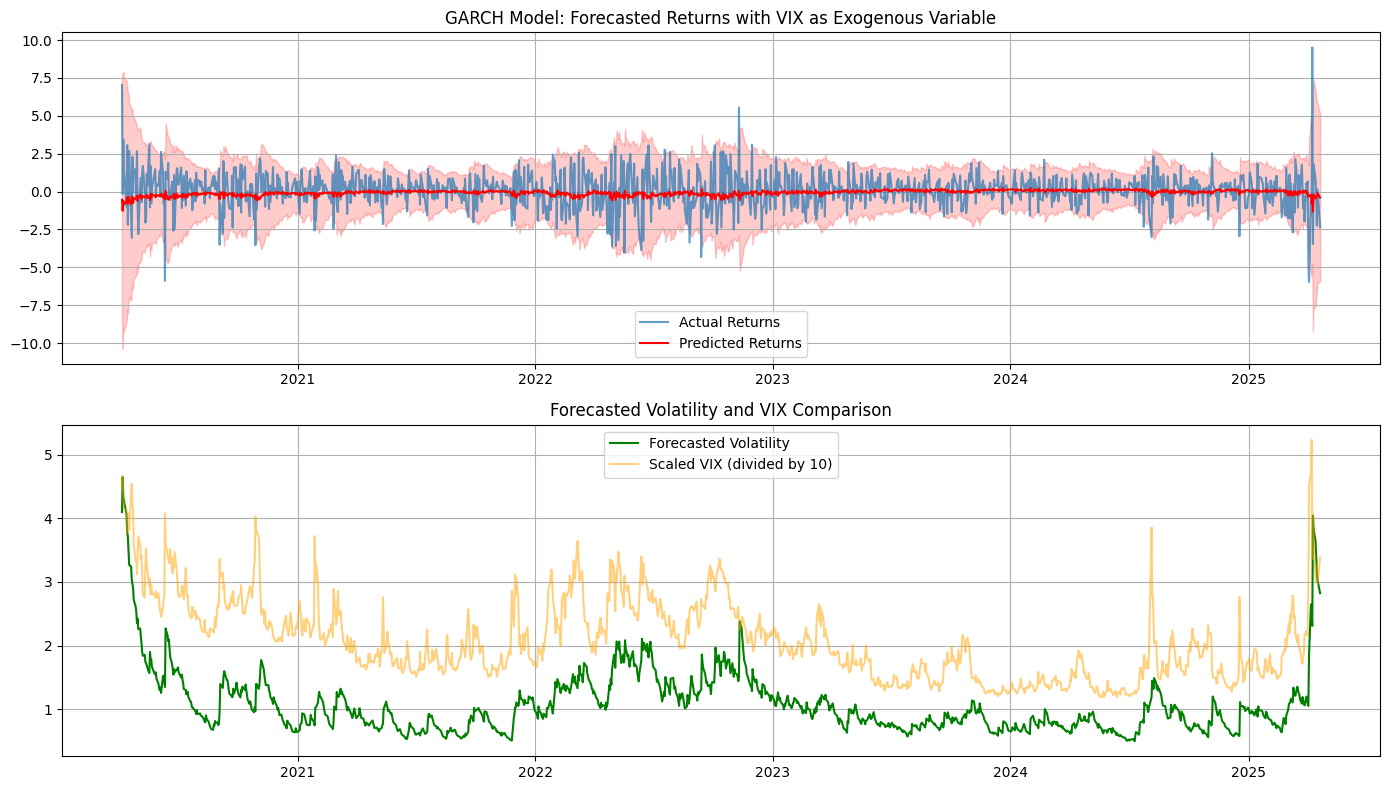

GARCH Return Prediction RMSE: 1.1514
GARCH Return Prediction MAE: 0.8170
Directional Accuracy: 56.20%
Correlation between predicted volatility and VIX: 0.7674


In [ ]:
# MODELO 3: GARCH with Exogenous Variables8

# Prepare daily returns for S&P 500
daily_returns = df['^GSPC']['Close'].pct_change().dropna() * 100  # Convert to percentage

# Prepare VIX as exogenous variable (aligned with returns)
vix_exog = df['^VIX']['Close'].reindex(daily_returns.index)

# Split data for training and testing
train_size = int(len(daily_returns) * 0.8)
train_returns = daily_returns[:train_size]
test_returns = daily_returns[train_size:]
train_vix = vix_exog[:train_size]
test_vix = vix_exog[train_size:]

# Set up the GARCH model with VIX as exogenous variable in the mean equation
from arch import arch_model

# Create a GARCH model with VIX in the mean equation
garch_model = arch_model(
    train_returns,
    vol='GARCH',
    p=1,
    q=1,
    mean='ARX',
    lags=1,
    x=train_vix.values.reshape(-1, 1),  # Add VIX as exogenous regressor in mean equation
    o=0,                                # No asymmetric term
    dist='normal'                       # Normal distribution
)

# Fit the model
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())

# Get conditional volatility from the model
conditional_vol = garch_result.conditional_volatility

# For forecasting with exogenous variables in ARX, we'll use rolling forecasts
# rather than trying to forecast the entire test period at once

# Initialize arrays to store forecasts
forecast_length = len(test_returns)
mean_forecasts = np.zeros(forecast_length)
volatility_forecasts = np.zeros(forecast_length)

# Rolling one-step ahead forecasts
for i in range(forecast_length):
    # If we're at the beginning, use the final values from the training set
    if i == 0:
        # Get last observation from training
        last_return = train_returns.iloc[-1]
        forecasted_vix = test_vix.iloc[0]

        # Create forecast parameters
        params = garch_result.params
        horizon = 1
        start = 0
        x = np.array([[forecasted_vix]])  # Shape needs to be (1, 1)

        # Generate forecast for first test point
        forecast = garch_result.forecast(params=params, horizon=horizon, start=None, x=x)
        mean_forecasts[i] = forecast.mean.iloc[0]['h.1']
        volatility_forecasts[i] = np.sqrt(forecast.variance.iloc[0]['h.1'])
    else:
        # Update with the most recent return
        # In a real implementation, you'd re-fit the model as new data comes in
        # Here, we'll just use the existing model parameters for simplicity
        last_return = test_returns.iloc[i-1]
        forecasted_vix = test_vix.iloc[i]

        x = np.array([[forecasted_vix]])  # Shape needs to be (1, 1)

        # For simplicity, we'll use a function that approximates the next forecast
        # This is a simplification - in practice, you should refit the model
        # or use a proper rolling forecast method

        # Approximate formula for GARCH(1,1) one-step ahead forecast
        # Mean: constant + AR(1) * last_return + exog * vix
        mean_forecasts[i] = (garch_result.params['Const'] +
                             garch_result.params['Close[1]'] * last_return +
                             garch_result.params['x0'] * forecasted_vix)

        # Variance: omega + alpha * last_squared_residual + beta * last_variance
        last_residual = last_return - mean_forecasts[i-1]
        last_variance = volatility_forecasts[i-1]**2

        new_variance = (garch_result.params['omega'] +
                        garch_result.params['alpha[1]'] * last_residual**2 +
                        garch_result.params['beta[1]'] * last_variance)

        volatility_forecasts[i] = np.sqrt(new_variance)

# Convert to pandas Series for easier plotting
mean_forecast = pd.Series(mean_forecasts, index=test_returns.index)
volatility_forecast = pd.Series(volatility_forecasts, index=test_returns.index)

# Calculate 95% confidence intervals
upper_ci = mean_forecast + 1.96 * volatility_forecast
lower_ci = mean_forecast - 1.96 * volatility_forecast

# Create a DataFrame for visualization
forecast_df = pd.DataFrame({
    'Predicted_Return': mean_forecast,
    'Upper_CI': upper_ci,
    'Lower_CI': lower_ci,
    'Actual_Return': test_returns
})

# Visualize results
plt.figure(figsize=(14, 8))

# Plot returns and predictions
plt.subplot(2, 1, 1)
plt.plot(test_returns.index, test_returns, label='Actual Returns', alpha=0.7)
plt.plot(mean_forecast.index, mean_forecast, label='Predicted Returns', color='red')
plt.fill_between(mean_forecast.index, lower_ci, upper_ci, alpha=0.2, color='red')
plt.title('GARCH Model: Forecasted Returns with VIX as Exogenous Variable')
plt.legend()
plt.grid(True)

# Plot conditional volatility and VIX
plt.subplot(2, 1, 2)
plt.plot(test_returns.index, volatility_forecast, label='Forecasted Volatility', color='green')
plt.plot(test_vix.index, test_vix/10, label='Scaled VIX (divided by 10)', color='orange', alpha=0.5)
plt.title('Forecasted Volatility and VIX Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate model performance for return prediction
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_garch = np.sqrt(mean_squared_error(test_returns, mean_forecast))
mae_garch = mean_absolute_error(test_returns, mean_forecast)

print(f"GARCH Return Prediction RMSE: {rmse_garch:.4f}")
print(f"GARCH Return Prediction MAE: {mae_garch:.4f}")

# Calculate directional accuracy (percentage of correct prediction of market direction)
direction_actual = np.sign(test_returns)
direction_pred = np.sign(mean_forecast)
directional_accuracy = np.mean(direction_actual == direction_pred) * 100

print(f"Directional Accuracy: {directional_accuracy:.2f}%")

# Examine correlation between predicted volatility and VIX
vol_vix_corr = np.corrcoef(volatility_forecast, test_vix)[0, 1]
print(f"Correlation between predicted volatility and VIX: {vol_vix_corr:.4f}")


Este modelo confirma varios comportamientos típicos del mercado:

El VIX tiene un efecto negativo y significativo sobre los retornos del S&P 500.
El mercado muestra reversión a la media a corto plazo.
La volatilidad persiste en el tiempo y responde a shocks recientes.
Aunque el modelo no esbueno para predecir los niveles exactos de los precios, es bastante útil para anticipar la dirección del mercado y los cambios en el riesgo. En especial, su componente GARCH lo hace ideal para estrategias de gestión de riesgo, ya que permite ajustar la exposición al mercado en función de la volatilidad esperada.



## Conclusiones del trabajo final

Respuesta a la pregunta de investigacion
# ¿Puede el índice VIX predecir los movimientos del S&P 500?

Sí, pero: el VIX mejora la predicción del S&P 500 cuando se modela como parte de un sistema dinámico (VAR) o como indicador de riesgo (GARCH); utilizado de forma aislada y lineal, su capacidad predictiva sobre el nivel del índice es mínima.

*Por tanto, el VIX es más valioso como medidor adelantado de volatilidad y riesgo que como predictor exacto de precio.*

### Comparacion de modelos

| Modelo                   | Frecuencia & Variable objetivo     | Exógenos             | RMSE    | MAE     | Métrica extra                    | Lectura práctica                                                                 |
|--------------------------|------------------------------------|----------------------|---------|---------|----------------------------------|----------------------------------------------------------------------------------|
| SARIMAX (1,0,1)          | Log-retorno mensual S&P 500        | —                    | 0.0506  | 0.0428  | —                                | Baseline: explica ≈ 0 % de la varianza; error ≈ volatilidad histórica de 5 %.   |
| SARIMAX + VIX (lag +1)   | Igual que arriba                   | VIX (−1 mes)         | 0.0515  | 0.0433  | —                                | El VIX no aporta señal: error sube ligeramente.                                  |
| VAR (6)                  | Log-retorno mensual S&P 500        | Log-retorno VIX      | 0.0374  | 0.0298  | Varianza explicada ≈ 25 %        | Gana al baseline; modelo multivariado reduce el error ≈ 26 %.                   |
| AR-X / GARCH (1,1)       | Retorno diario S&P 500 (%)         | VIX (nivel diario)   | 1.151 % | 0.817 % | Direcc. ↑ 56 %, Corr(VIX)=0.77   | Error similar a la volatilidad; útil como termómetro de riesgo, señal modesta.  |



Analizamos varios modelos para predecir el comportamiento del S&P 500. Empezamos con un modelo **SARIMAX** básico para los rendimientos mensuales, que tuvo un error cercano al 5%, similar a la volatilidad histórica. Esto sugiere que sin información adicional, el índice se comporta casi como ruido aleatorio con ligera autocorrelación.

Cuando intentamos mejorar este modelo añadiendo el índice VIX con un mes de retraso, descubrimos que esta información adicional no ayudó en absoluto. El error incluso aumentó ligeramente, y los coeficientes no fueron estadísticamente significativos. Parece que a nivel mensual, el S&P 500 refleja mejor su propia dinámica que el nivel de volatilidad aislado.

El modelo **VAR**, que analiza simultáneamente los rendimientos del S&P 500 y del VIX, mostró resultados mucho más prometedores. Redujo el error aproximadamente un 26% comparado con el modelo básico y explicó cerca del 25% de la variabilidad mensual. También confirmó la relación que esperábamos: los aumentos en el VIX suelen preceder a caídas moderadas en el índice. Este es claramente el modelo más preciso para predicciones mensuales.

Para datos diarios, aplicamos un modelo **AR-X + GARCH** que resultó particularmente útil para gestionar el riesgo. Su pronóstico de volatilidad tuvo una correlación de 0.77 con el VIX y logró un 56% de acierto en la dirección del mercado. Aunque el error diario ronda el 1% (similar a la volatilidad diaria normal), este modelo destaca por su capacidad para detectar picos de incertidumbre y ayudar a ajustar posiciones en mercados volátiles.

*En resumen, el modelo VAR es la mejor opción para predecir rendimientos mensuales, mientras que el AR-X + GARCH resulta más útil para gestionar el riesgo diario. Cada uno tiene su propósito específico dependiendo de lo que necesitemos predecir.*


## Conclusión final

Los datos financieros son muy ruidosos y no siempre siguen patrones lineales, lo que limita los modelos estadísticos tradicionales. Esto nos dejó con la idea de que podríamos probar modelos más modernos, como LSTM o transformers, en el futuro.
Aprendimos que los mercados financieros tienen un comportamiento caótico y son difíciles de predecir a largo plazo. Esto se debe a su naturaleza compleja y a la influencia constante del comportamiento humano. Aunque el VIX es útil para entender el riesgo a corto plazo, los modelos clásicos tienen límites importantes. Por eso, creemos que una mejor aproximación sería usar modelos más avanzados de deep learning, que incluyan muchas más variables relacionadas con el mercado, como tasas de interés, sentimiento de los inversores y datos económicos. Así se podrían captar mejor las dinámicas reales del mercado y mejorar las predicciones en escenarios más complejos.